# Stitch Images
### Use SWIFT key point to find matches on both images that we can use to stitich images together


In [50]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import sys 
import os
import skimage.io

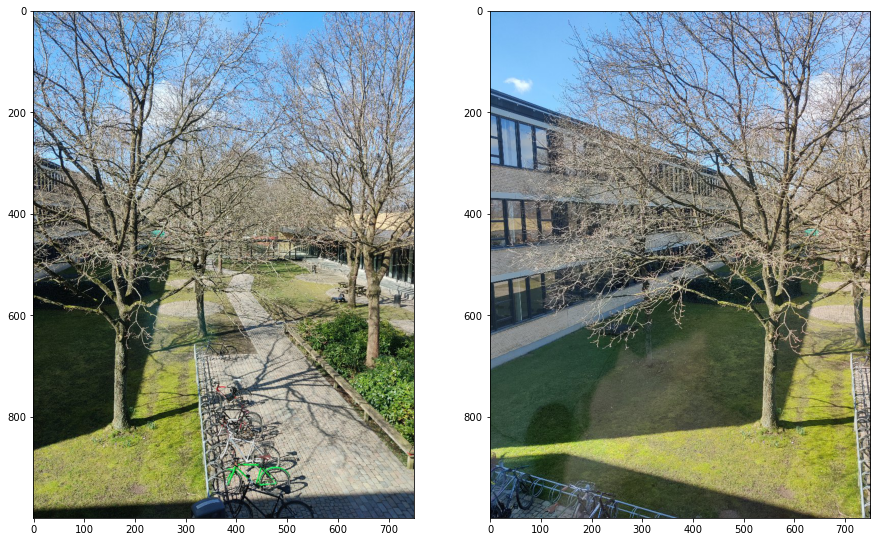

In [51]:
# Read the images 
im1 = skimage.io.imread('im1.jpg')
im2 = skimage.io.imread('im2.jpg')

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(im1)
ax[1].imshow(im2)

### Use CV2 to detect the matches and descriptors
https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

In [52]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

# BFMatcher with default params, Find the keypoints 
# For each descriptor in the first set, this matcher finds the closest descriptor in
# the second set by trying each one. This descriptor matcher supports masking permissible 
# matches of descriptor sets.
bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(des1,des2)
     
print('Number of matches:',len(matches))

Number of matches: 2455


#### Visualize the matches in boh images 

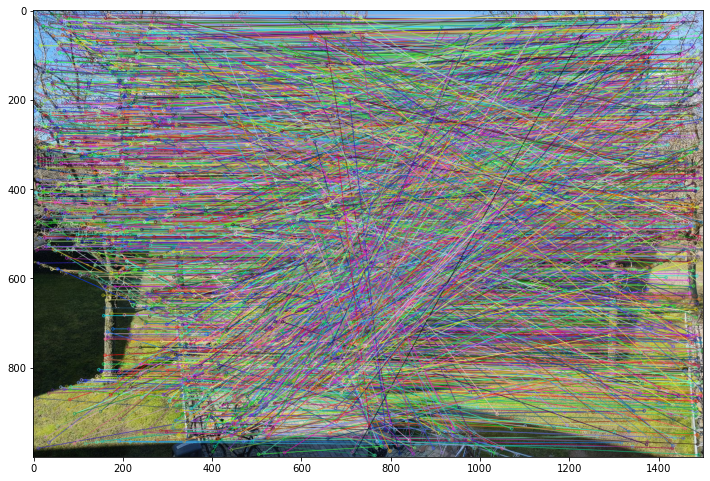

In [53]:
img3 = cv2.drawMatches(im1, kp1, im2, kp2, matches, None, flags=2)
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img3)

## Use RANSAC algorithm to estimate the Homography matrix:<br>
We have 9 unknowns as the Homography it's 3 by 3. As we can only compute the homography matrix up to a scale Factor, we drop one of unknows. Overall we have 8 constrains. So we'll need 4 pair of points to solve these 8 constrains. <br>
For numerically estability and better accuracy in the estimation we'll always try to use the maximum number of matches.

In [54]:
def select_points_from_matches(matches, num_pairs:int=None)->list:
    """
    Given the matches from 2 images obtained with cv2.BFMatcher, we select a number of pairs points.
    
    PARAMETERS:
    Matches-> cv2.DMatch objects
    num_pair_points -> number of pair points we want to select on both images
    
    RETURNS:
    list_kp1: 2d array dimensions (3,num_pairs). Colection of points in homogenous form [x, y, 1]^T from the 1st image.
    list_kp2: 2d array dimensions (3,num_pairs). Colection of points in homogenous form [x, y, 1]^T from the 2nd image.
    """
    
    if num_pairs:
        # Select n number of pairs random matches 
        matches_tmp = np.random.choice(matches, num_pairs, replace=False)
        
        # Initialize arrays 
        list_kp1 = np.zeros((3, num_pairs))
        list_kp2 = np.zeros((3, num_pairs))
    else: 
        # If we don't specify the number of points, we simply select all the points
        matches_tmp = matches
        # Initialize arrays 
        list_kp1 = np.zeros((3, len(matches)))
        list_kp2 = np.zeros((3, len(matches)))

    
    # Convert the match DMatch object into points 
    
    # For each match...
    for i, mat in enumerate(matches_tmp):

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx # The index or row of the kp1 interest point matrix that matches
        img2_idx = mat.trainIdx # The index or row of the kp2 interest point matrix that matches

        # x - columns
        # y - rows
        # Get the coordinates
        point_im1 = np.r_[np.array(kp1[img1_idx].pt), 1]
        point_im2 = np.r_[np.array(kp2[img2_idx].pt), 1]

        # Append to each list
        list_kp1[:,i] = point_im1
        list_kp2[:,i] = point_im2
    
    return list_kp1, list_kp2

In [55]:
p1, p2 = select_points_from_matches(matches, 4)
p1.shape, p2.shape

((3, 4), (3, 4))

In [56]:
def crossOp(v):
    """
    v: Vector. The dimensions doesn't matter. Must be a 3d vector
    Cv : It's the cross operation between the vector and itself. It follows the skew-symmetric matrix form 
    """
    # Check the vector has appropiate form, we want a (3,) 
    if v.shape == (3,1):
        v = np.squeeze(v, axis=1)
    elif v.shape == (1,3):
        v = np.squeeze(v, axis=0)
    else:
        pass
            
    Cv = np.matrix(np.array([[0, -v[2], v[1]],[v[2], 0, -v[0]], [-v[1], v[0], 0]]))
    return Cv

In [57]:
def squeezdim(v):
    """
    Function that squeezes a vetor into a the form (n,)
    v: vector of dimension n.     
    """
    try:
        m,n = v.shape
    except ValueError:
        return v
    if m>n: 
        v = np.squeeze(v, axis=1)
    else:
        v = np.squeeze(v, axis=0)
    return v

In [58]:
def matrix_B(q1, q2):
    """
    Creates a B matrix applying Kroneker product. 
        -1st. Corssproduct on vector q in itslef (qxq):  Uses the approach of a skew symetric matrix.
        -2nd. Krokener product: B = Qi⊗[qi]x
        
    We estimate B in order to find the Homography matrix: 
        - Estimate the Homography matrix:
            We want to relate a set of points on 2D with a set of points in 2D. 
            q1 = [x, y]
            q2 = [x, y]

    
    ARGUMENTS 
    q1-> 2d point in Homogenous form. (3,1) -> [x, y, 1]^T
    q2-> 2d point in Homogenous form. (3,1) -> [x, y, 1]^T
    
    RETURNS:
    B -> Matrix created with kroneker product
    """
    
    # Squeez dimesions of q to apply Cross Operation 
    q1 = squeezdim(q1)

    # Create the Skeweness matrix [p1]x
    q1 = crossOp(q1)
    
    # Squeeze vector Q
    q2 = squeezdim(q2)
    
    # Appply Kroneker Product
    for i in range(len(q2)):
        # Check if the first element it's 0 to create matrix
        if not i:
            B = q2[i] * q1
        else:  # If it's not the first element just concatenate the matrices
            B = np.concatenate((B, q2[i]*q1),1)
    return B

In [59]:
def hest(Q1, Q2):
    """
    Estimation of the homography matrix. 
    Given a set of points, (min should be 4 points, as the homography has 8 degrees of freedom) calculates the B matrix
    and applies singular value decomposition (SVD) to estimate the homography matrix H.
    
    Following the equation: q1 x H*q2:
        q1: 2D points in inhomogeneous form. [x, y].T 
        q2: 2D points in inhomogeneous form. [x, y].T
        H: Homography matrix (3,3)
    
    ARGUMENTS:
    Q1-> set of 2D points in Homogenous form. (3,n)
    Q2-> set of 2D points in homogenous form. (3,n)
    
    RETURNS
    H-> Estimation of the Homography Matrix (3,3)
    """
    
    # Check the dimensions and if the same poits were given.
    Q1 = np.array(Q1)
    Q2 = np.array(Q2)

    # Check the same number of pooints were given 
    if Q1.shape != Q2.shape:
        print("Different number of points were given, check that Q1 and Q2 have same dimensions")
        return
    n = Q1.shape[1]
    # Calculate B Matrix 
    for i in range(n):
        if not i:
            B = matrix_B(Q1[:,i],Q2[:,i])
        else:
            B = np.concatenate([B, matrix_B(Q1[:,i], Q2[:,i])])
    
    # Estimation of H: SVD
    _, s, eigenvec = np.linalg.svd(B)
    # Find the min Eigenvalue
    idx = np.where(s==min(s))
    # Select the eigenvector correspondent to the eigenvalue
    H = eigenvec[idx]
    # Reshape the array into a matrix form 
    H = H.reshape((3,3), order='F')
    # Scale it 
    H = H/H[-1,-1]

    return H

In [60]:
H_est = hest(p1,p2)
H_est

matrix([[-1.48541084e+00, -2.18190787e+00,  5.15746144e+02],
        [-2.28139040e+00, -2.03792287e+00,  6.08514499e+02],
        [-3.23953547e-03, -3.66380924e-03,  1.00000000e+00]])

In [61]:
def inhom(Q):
    """
    Returns the Point/s Q in inhomogenous form. 
    Given Q divides by the scale:
        - 2D points:
            [sx, sy, s]/s = [x, y, 1] and we return [x, y]
        - 3D points:
            As the scale is 1 we divide by one and return everything but the last column.
    
    ARGUMENTS
    ---------
    Q -> Point or set of points in the form of column vector. (3, n) or in case of 3d points (4,n)
    
    RETURNS
    -------
    Q_tmp -> Points in inhomogenous form. 2d: (2,n), 3d: ()
    """
    # Get the scale 
    s = Q[-1,:]
    
    # Divide by the scale at select everything but the last row
    Q_tmp = (Q/s)[:-1,:]
    
    return Q_tmp

In [62]:
def dist_point_homography(H,p1,p2):
    """
    Given an Homography matrix and 2 matching points from to different Images, calculates the distance between these
    two points once we have "projected" the points into the second point plane.
    
        d = ||Π(Hp2) − Π(p1)||^2 + ||Π(H−1p1i) − Π(p2i)||^2 
            
            u = ||Π(Hp2) − Π(p1)||^2
            v = ||Π((H^-1)p1) − Π(p2)||^2
                     
        Computing the norm of a vector as default norm 2.
        
    ARGUMENTS
    ---------
    H  -> Homography matrix 
    p1 -> Point 2d in homogenous coordinates (3,n)
    p2 -> Point 2d in homogenous coordinates (3,n)
    
    RETURNS
    -------
    d -> Distance from pq to p2 
    """
    # Calculate the invers og the homogaphy 
    H_inv = np.linalg.inv(H)

    # Compute norm of the vectors separately
    u = np.sqrt(np.sum(np.array(inhom(H@p2)-inhom(p1))**2, axis = 0))
    v = np.sqrt(np.sum(np.array(inhom(H_inv@p1) - inhom(p2))**2, axis=0))
    
    # Compute distance
    d = u + v
    
    return d

In [63]:
d = dist_point_homography(H_est, p1, p2)
d

array([4.16751791e-08, 1.38770977e-08, 7.04091198e-09, 1.22985020e-08])

Now we can run a RANSAC algorithm. Set the threshold to:

$\tau = 3.84*\sigma^2$ <br>
$\tau = 3.84*3^2  = 34.47$

In [64]:
def isinlier(H, p1, p2, sigma:int=3):
    """
    
    Given a set of points1 and a set of points2 
    
        Given a sigma, calculates the tau, minumum distance to consider the point an outlier in the RANSAC algorithm.
    
    ARGUMENTS
    ---------
    H  -> Homography matrix (3,3)
    p1 -> Point 2d in homogenous coordinates (3,n)
    p2 -> Point 2d in homogenous coordinates (3,n)
    
    RETURNS
    -------
    d -> boolean array.

    """
    
    # Caclulate threshold 
    tau = 3.84*sigma**2
    
    # Calculate distance 
    d = dist_point_homography(H_est, p1, p2)
    
    return d<tau    

In [66]:
inlier = isinlier(H_est, p1, p2)
inlier

array([ True,  True,  True,  True])

As we are using these for points to estimate the homography matrix, the points we are using will normally be inliers

### Check the all the points for innliers and outliers 

In [79]:
points1, points2 = select_points_from_matches(matches)
points1.shape

(3, 2455)

In [80]:
d_t = isinlier(H_est, points1, points2)
points1.shape

(3, 2455)

In [81]:
d_t.shape, sum(d_t)

((2455,), 6)

In [134]:
def RANSAC(matches, n_iterations:int=200):
    
    # Initialize some variables 
    N_opt = 0 
    H_opt = None 
    points1_opt = None 
    points2_opt = None 
    
    # Convert the matches into points
    points1, points2 = select_points_from_matches(matches)
    
    # Iterate until we obtain an optimal homography matrix 
    for i in range(n_iterations):
        # Print number of iterations
        if i % 10 == 0:
            print(f'Iteration number: {i}')
            
        # Select 4 pair of points 
        p1, p2 = select_points_from_matches(matches, 4)
        
        # Estimate the Homography matrix from the 4 pair of points.
        H_tmp = hest(p1,p2)
        
        # Calculate the inliers of all the points 
        inliers_idx = isinlier(H_tmp, points1, points2)
        
        N_tmp = sum(inliers_idx)

        # Check if we have more inliers in this iteration
        if N>N_opt:
            N_opt = N_tmp
            H_opt = H_tmp
            if (H_tmp == H_tmp).all():
                print('Problem')
            points1_opt = points1[:, inliers_idx]
            points2_opt = points2[:, inliers_idx]
       

    return N_opt, H_opt, points1_opt, points2_opt    

In [135]:
N, H, poin1, poin2 = RANSAC(matches)

Iteration number: 0
Problem
Iteration number: 10
Iteration number: 20
Iteration number: 30
Iteration number: 40
Iteration number: 50
Iteration number: 60
Iteration number: 70
Iteration number: 80
Iteration number: 90
Iteration number: 100
Iteration number: 110
Iteration number: 120
Iteration number: 130
Iteration number: 140
Iteration number: 150
Iteration number: 160
Iteration number: 170
Iteration number: 180
Iteration number: 190


In [128]:
H

matrix([[-3.67836123e-01, -2.75230033e-01,  4.30985102e+02],
        [-2.79985816e-01, -7.35165969e-01,  8.31582447e+02],
        [-3.67439734e-04, -8.24203555e-04,  1.00000000e+00]])

In [129]:
H_est

matrix([[-1.48541084e+00, -2.18190787e+00,  5.15746144e+02],
        [-2.28139040e+00, -2.03792287e+00,  6.08514499e+02],
        [-3.23953547e-03, -3.66380924e-03,  1.00000000e+00]])

In [133]:
(H == H_est).any()

True